Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from tensorflow.keras.layers import Conv2D,Dropout,Dense,MaxPool2D,Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
tf.__version__

'2.8.0'

In [4]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4214409589181023969
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16394203826074768549
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [7]:
print(tf.test.gpu_device_name())

/device:GPU:0


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
filepath = r'/content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/'
data_dir_train = pathlib.Path(filepath + 'Train')
data_dir_test = pathlib.Path(filepath + 'Test')

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [12]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Train Data Viz.
******************************


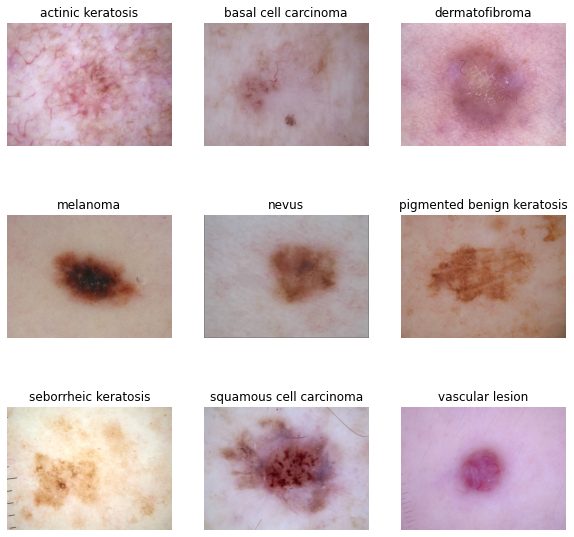

Validation Data Viz.
******************************


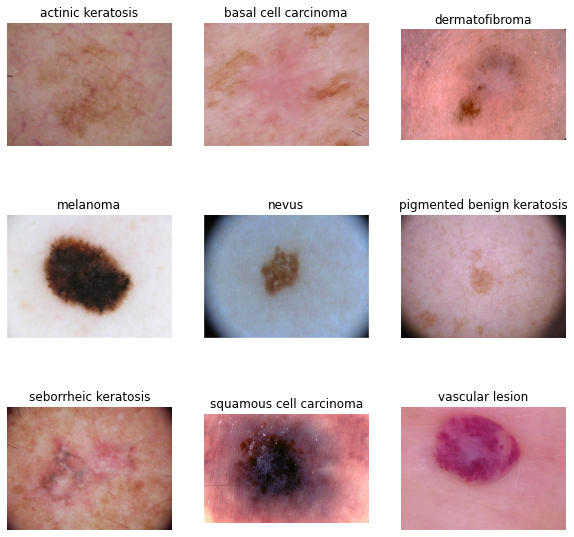

In [ ]:
plt.figure(figsize=(10,10))
print('Train Data Viz.')
print('*'*30)
for i in range(9): 
    plt.subplot(3, 3, i + 1)
    image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)
    plt.axis('off')

plt.show()

plt.figure(figsize=(10,10))
print('Validation Data Viz.')
print('*'*30)
for i in range(9): 
    plt.subplot(3, 3, i + 1)
    image = plt.imread(str(list(data_dir_test.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)
    plt.axis('off')
    
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
num_classes = len(class_names)

In [ ]:
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
crossentropy = SparseCategoricalCrossentropy(
    from_logits=False, name="sparse_categorical_crossentropy"
)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=crossentropy,
              metrics=['accuracy'])

EarlyStopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5
)

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  #callbacks = [EarlyStopping]
)

Epoch 1/30
169/169 [==============================] - 826s 1s/step - loss: 2.1404 - accuracy: 0.1595 - val_loss: 2.2158 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 27s 161ms/step - loss: 1.8455 - accuracy: 0.2865 - val_loss: 1.7322 - val_accuracy: 0.3304
Epoch 3/30
169/169 [==============================] - 27s 161ms/step - loss: 1.6079 - accuracy: 0.3793 - val_loss: 1.4786 - val_accuracy: 0.4343
Epoch 4/30
169/169 [==============================] - 27s 161ms/step - loss: 1.4458 - accuracy: 0.4542 - val_loss: 1.5000 - val_accuracy: 0.4016
Epoch 5/30
169/169 [==============================] - 27s 161ms/step - loss: 1.3744 - accuracy: 0.4766 - val_loss: 1.5085 - val_accuracy: 0.4209
Epoch 6/30
169/169 [==============================] - 27s 161ms/step - loss: 1.2421 - accuracy: 0.5384 - val_loss: 1.1968 - val_accuracy: 0.5523
Epoch 7/30
169/169 [==============================] - 27s 161ms/step - loss: 1.1084 - accuracy: 0.5820 - val_loss: 1.1057 - val_accu

### Visualizing training results

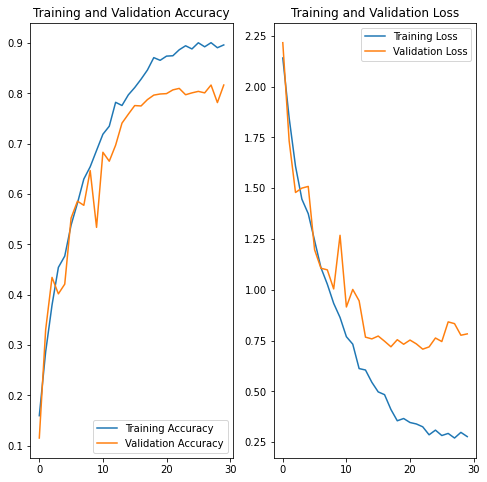

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit



*   The model is overfitting 
*   The accuracy is just around 80% because there are enough features to remember the pattern.






### Write your findings here

In [58]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip,RandomRotation,RandomZoom
data_augument = keras.Sequential([
                             RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             RandomRotation(0.2, fill_mode='reflect'),
                             RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

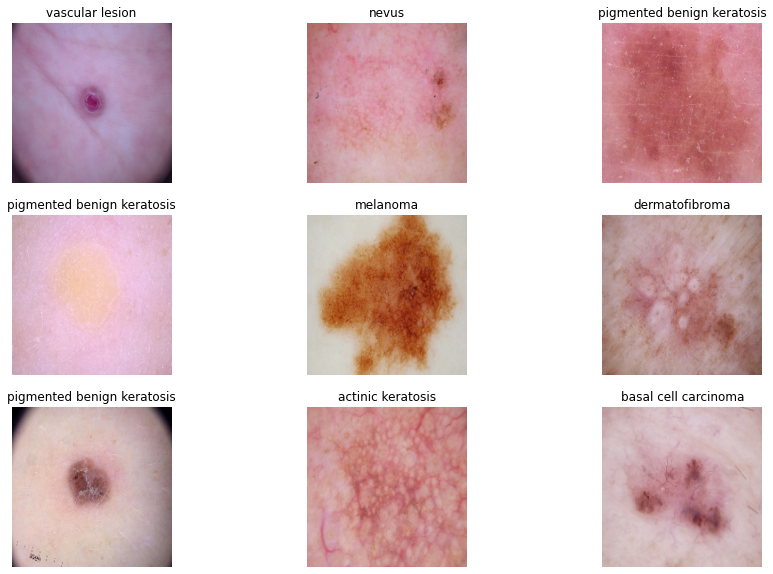

In [59]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [60]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = len(class_names)

model = Sequential([ data_augument,layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [61]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
crossentropy = SparseCategoricalCrossentropy(
    from_logits=False, name="sparse_categorical_crossentropy"
)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=crossentropy,
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        25632     
                                                      

### Training the model

In [63]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  #callbacks = [EarlyStopping]
)

Epoch 1/30
56/56 [==============================] - 190s 3s/step - loss: 2.0610 - accuracy: 0.1769 - val_loss: 2.0359 - val_accuracy: 0.2058
Epoch 2/30
56/56 [==============================] - 21s 344ms/step - loss: 2.0359 - accuracy: 0.2026 - val_loss: 2.0319 - val_accuracy: 0.2058
Epoch 3/30
56/56 [==============================] - 21s 342ms/step - loss: 2.0221 - accuracy: 0.2098 - val_loss: 2.0375 - val_accuracy: 0.2036
Epoch 4/30
56/56 [==============================] - 21s 343ms/step - loss: 2.0241 - accuracy: 0.2026 - val_loss: 2.0484 - val_accuracy: 0.2081
Epoch 5/30
56/56 [==============================] - 21s 342ms/step - loss: 2.0181 - accuracy: 0.2054 - val_loss: 2.0320 - val_accuracy: 0.2058
Epoch 6/30
56/56 [==============================] - 21s 342ms/step - loss: 2.0209 - accuracy: 0.1981 - val_loss: 2.0268 - val_accuracy: 0.2058
Epoch 7/30
56/56 [==============================] - 21s 341ms/step - loss: 2.0165 - accuracy: 0.1959 - val_loss: 2.0274 - val_accuracy: 0.2058
E

### Visualizing the results

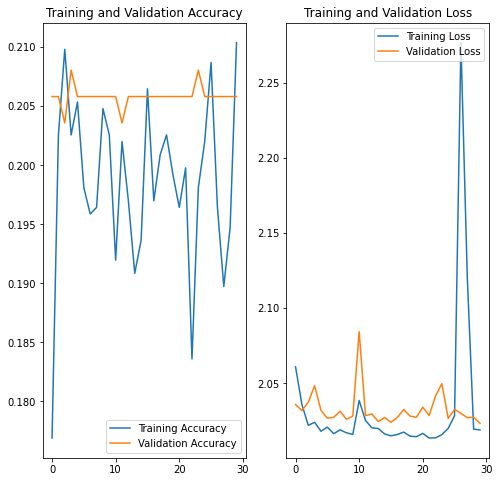

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?



*   Accuracy became very less but we can definitely see the overfitting problem has solved due to data augmentation




#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [15]:
## Your code goes here.

path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Melanoma Case Study/Dat...,actinic keratosis
1,/content/drive/MyDrive/Melanoma Case Study/Dat...,actinic keratosis
2,/content/drive/MyDrive/Melanoma Case Study/Dat...,actinic keratosis
3,/content/drive/MyDrive/Melanoma Case Study/Dat...,actinic keratosis
4,/content/drive/MyDrive/Melanoma Case Study/Dat...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Melanoma Case Study/Dat...,vascular lesion
2235,/content/drive/MyDrive/Melanoma Case Study/Dat...,vascular lesion
2236,/content/drive/MyDrive/Melanoma Case Study/Dat...,vascular lesion
2237,/content/drive/MyDrive/Melanoma Case Study/Dat...,vascular lesion


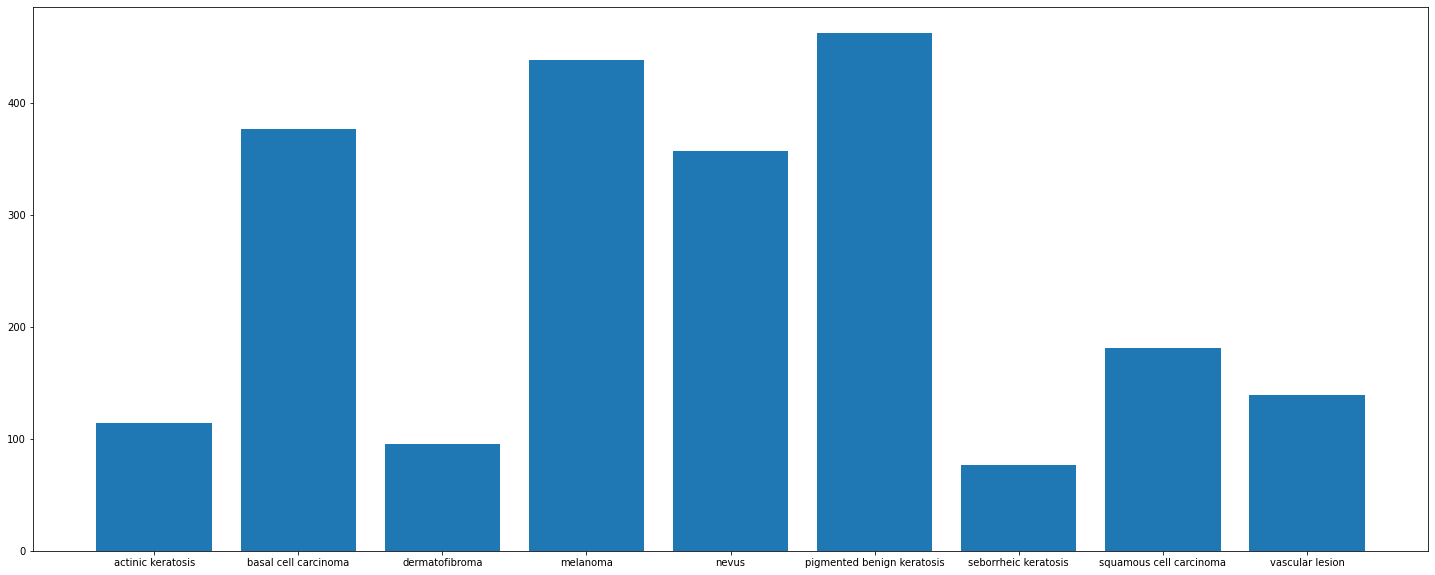

In [16]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?



*    squamous cell carcinoma has least number of samples

*   melanoma and pigmented benign keratosis have proprtionate number of classes



 

*   actinic keratosis and dermatofibroma have proportionate number of classes.




#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [17]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


### Deteing the Object Folder

In [21]:
import shutil
filepath = '/content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
for name in class_names:
  for folder in os.listdir(filepath+name):
    if folder.endswith('output') == True:
      shutil.rmtree(filepath+name+"/"+folder)

In [22]:
path_to_training_dataset="/content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3E3E994E90>: 100%|██████████| 500/500 [00:24<00:00, 20.59 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3E3CFC21D0>: 100%|██████████| 500/500 [00:22<00:00, 22.28 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3E3D00E2D0>: 100%|██████████| 500/500 [00:22<00:00, 21.97 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3E3D0635D0>: 100%|██████████| 500/500 [02:00<00:00,  4.14 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F3E3E942790>: 100%|██████████| 500/500 [01:49<00:00,  4.56 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3E3E942F50>: 100%|██████████| 500/500 [00:21<00:00, 22.80 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3E3D05A450>: 100%|██████████| 500/500 [00:50<00:00,  9.94 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3E3D048D50>: 100%|██████████| 500/500 [00:24<00:00, 20.65 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3F42C14CD0>: 100%|██████████| 500/500 [00:24<00:00, 20.65 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [23]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [24]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028406.jpg_93713611-4293-4d35-b1c3-52efcd00c1c2.jpg',
 '/content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027672.jpg_c7fdaca5-b0d0-4ae2-b025-a0a1af03b785.jpg',
 '/content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025425.jpg_013cde45-1745-4ea5-8d5e-c85a38b85666.jpg',
 '/content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024904.jpg_58bc9b72-0782-4977-a21d-c94622812005.jpg',
 '/content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imagin

In [25]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [26]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [27]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [28]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [29]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [30]:
data_dir_train=pathlib.Path("/content/drive/MyDrive/Melanoma Case Study/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [31]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [33]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = len(class_names)

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [34]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
crossentropy = SparseCategoricalCrossentropy(
    from_logits=False, name="sparse_categorical_crossentropy"
)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=crossentropy,
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

#### **Todo:**  Train your model

In [36]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  #callbacks = [EarlyStopping]
)

Epoch 1/30
169/169 [==============================] - 53s 287ms/step - loss: 2.0836 - accuracy: 0.1907 - val_loss: 1.8758 - val_accuracy: 0.2702
Epoch 2/30
169/169 [==============================] - 50s 285ms/step - loss: 1.7659 - accuracy: 0.3151 - val_loss: 1.5996 - val_accuracy: 0.4001
Epoch 3/30
169/169 [==============================] - 48s 275ms/step - loss: 1.5391 - accuracy: 0.4149 - val_loss: 1.4753 - val_accuracy: 0.4655
Epoch 4/30
169/169 [==============================] - 48s 276ms/step - loss: 1.3559 - accuracy: 0.4952 - val_loss: 1.3019 - val_accuracy: 0.5256
Epoch 5/30
169/169 [==============================] - 48s 276ms/step - loss: 1.1675 - accuracy: 0.5734 - val_loss: 1.5152 - val_accuracy: 0.4551
Epoch 6/30
169/169 [==============================] - 48s 278ms/step - loss: 1.0252 - accuracy: 0.6352 - val_loss: 1.1409 - val_accuracy: 0.5999
Epoch 7/30
169/169 [==============================] - 49s 279ms/step - loss: 0.8708 - accuracy: 0.6845 - val_loss: 1.0822 - val_ac

#### **Todo:**  Visualize the model results

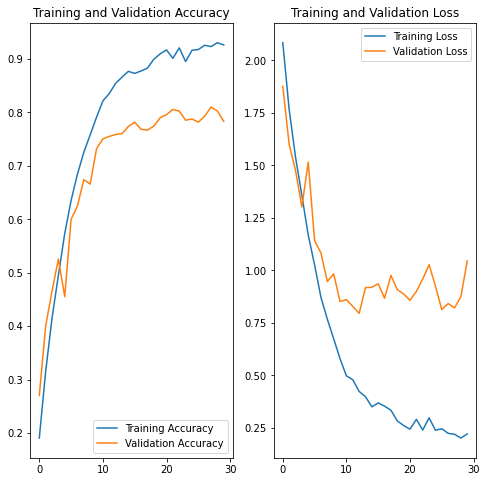

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?





*  Accuracy on training data has increased by using Augmentor library but accuracy on validation data has no been increased so we can say model is still overfitting


